# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

In [2]:
data = pd.read_csv('recipe_site_traffic_2212.csv')

**Data Validation**

Let us first have a look of our dataset without touching anything to avoid data leakage later in model development.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [4]:
len(data.recipe.unique())

947

In [5]:
print(data.category.unique())
print(data.servings.unique())

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
['6' '4' '1' '2' '4 as a snack' '6 as a snack']


In [6]:
data[data.servings.str.len()>1]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
451,452,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High
548,549,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High
735,736,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,NaN


We observe that all recipe numbers are unique. It implies that we do not have any duplicate.

We have missing values for 'calories', 'carbohydrates', 'sugar' and 'protein'. We will later impute these missing values.

We have missing values for 'high_traffic'. In this column, the value is 'High' if it corresponds to a high traffic recipe and NaN if not. We will replace 'High' by 1 and the missing values by 0.

Regarding the 'category' column, except for the values 'Chicken Breast' which we will need to replace by 'Chicken', the values correspond to the ones expected.

Regarding the 'servings' column, we have 3 unexpectd values : 'X as a snack', with X equal to 4 or 6. We change these values to the first character, i.e. the number. This is coherent since they all fall in the meal category 'Lunch/Snacks'.

We will also need to change the type of some columns:
- 'category' will be changed to categorical type
- 'servings' will be changed to categorical type

We will also have to deal with outliers in the numerical columns.

To avoid any data leakage, the imputation of the missing values in the numerical columns and the treatment of outliers will be done after the split of the data. For now, we only proceed to the necessary cleaning to visualize our data.

In [7]:
# In 'high_traffic': Replace 'High' by 1 and Nan by 0. 

data['high_traffic'] = np.where(data['high_traffic'] == 'High',1,0)

# Drop 'recipe'
data.drop(['recipe'], axis = 1, inplace = True)

# In 'category': Replace 'Chicken Breast' by 'Chicken'. Change type to category
data.loc[data['category']== 'Chicken Breast', 'category'] = 'Chicken'
data['category'] = data['category'].astype('category')

# Modify the unexpected values in 'servings'. Change type to category
data['servings'] = data['servings'].str[0].astype('category')

To proceed to the exploratory analysis part, we drop the missing values. We create the 'data_exp' DataFrame.

In [8]:
data_exp = data.dropna(axis = 0)

**Exploratory Analysis**

In [9]:
data_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 895 entries, 1 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 non-null    float64 
 3   protein       895 non-null    float64 
 4   category      895 non-null    category
 5   servings      895 non-null    category
 6   high_traffic  895 non-null    int64   
dtypes: category(2), float64(4), int64(1)
memory usage: 44.3 KB


Let us look at the distribution of high and low traffic recipes. We approximately have 60% of high traffic recipe. This will be used as a baseline to evaluate our models.

In [10]:
data_exp['high_traffic'].value_counts(normalize = True).round(3)

high_traffic
1    0.598
0    0.402
Name: proportion, dtype: float64

[Text(0, 0, 'Low'), Text(1, 0, 'High')]

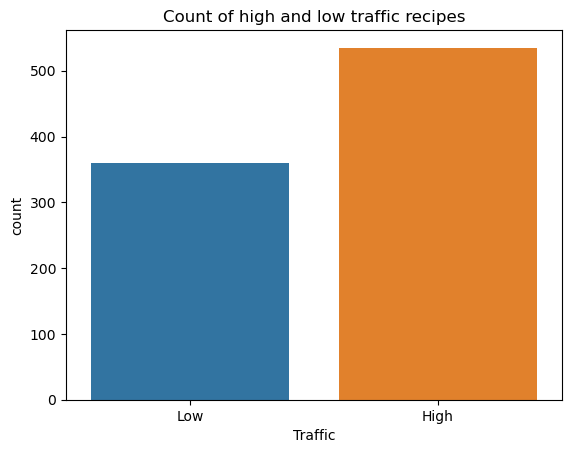

In [11]:
fig, ax = plt.subplots()
sns.countplot(data =data_exp, x = 'high_traffic', ax = ax)
plt.title('Count of high and low traffic recipes')
ax.set_xlabel('Traffic')
ax.set_xticklabels(['Low', 'High'])

The most represented category is chicken. The other categories appear in comparable numbers, as we can see on the plot below.


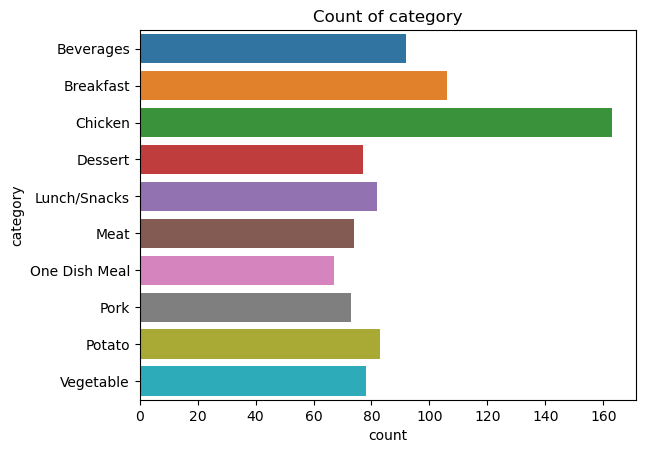

In [12]:
sns.countplot(data = data_exp, y = 'category')
plt.title('Count of category')
plt.show()

Some recipe categories like vegetables, potato or pork seem to bring high traffic whereas beverages and breakfast seem to be associated with low traffic as can be seen on the next figure.

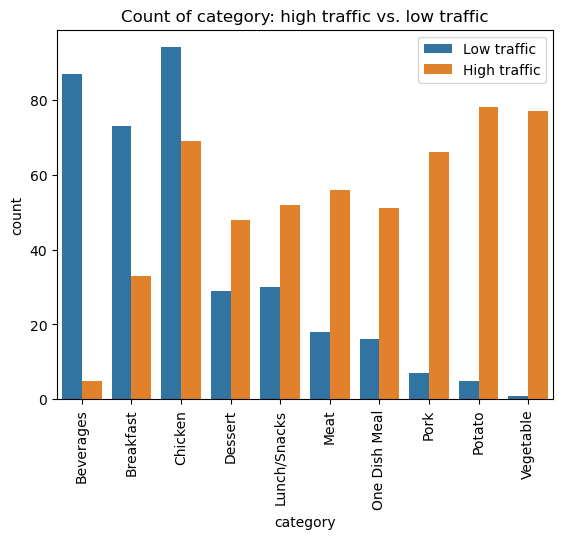

In [13]:
sns.countplot(data = data_exp, x = 'category', hue = 'high_traffic')
plt.xticks(rotation = 90)
plt.title('Count of category: high traffic vs. low traffic')
plt.legend(['Low traffic','High traffic'])
plt.show()

Servings seem to have a limited impact on traffic. The category on which the effect is more noticeable is '4 servings'.

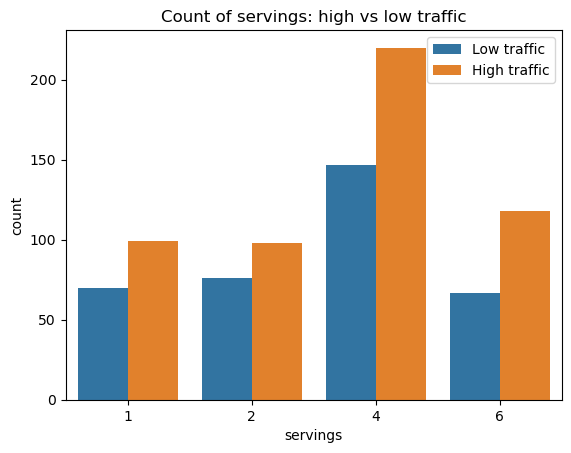

In [14]:
sns.countplot(data=data_exp, x= 'servings', hue='high_traffic', order = ['1','2','4','6'])
plt.title('Count of servings: high vs low traffic')
plt.legend(['Low traffic','High traffic'])


Let us look at the distribution of nutriments vs servings. For all nutriments, the number of servings does not have any influence of the quantity of nutriments. This confirms what was only specified in the example: these are the nutritional informations per serving.

We observe the presence of outliers in the high values, none in the low values.

<Axes: xlabel='servings', ylabel='protein'>

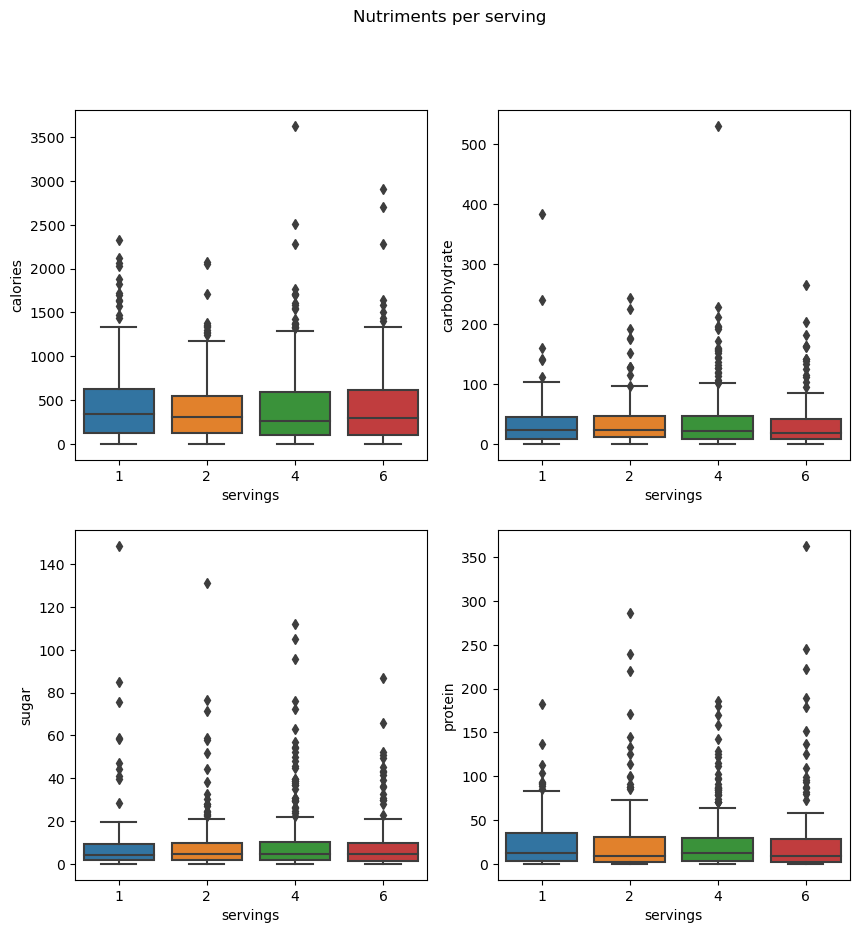

In [15]:
fig, axs = plt.subplots(2,2, figsize = [10,10])
fig.suptitle('Nutriments per serving')

sns.boxplot(data = data_exp, x= 'servings', order = ['1','2','4','6'], y = 'calories',ax = axs[0,0])
sns.boxplot(data = data_exp, x= 'servings', order = ['1','2','4','6'], y = 'sugar',ax = axs[1,0])
sns.boxplot(data = data_exp, x= 'servings', order = ['1','2','4','6'], y = 'carbohydrate',ax = axs[0,1])
sns.boxplot(data = data_exp, x= 'servings', order = ['1','2','4','6'], y = 'protein',ax = axs[1,1])

We plot the distribution of nutriments against the meal's category. Unsurprisingly, there are huge differences between categories.

<Axes: xlabel='category', ylabel='protein'>

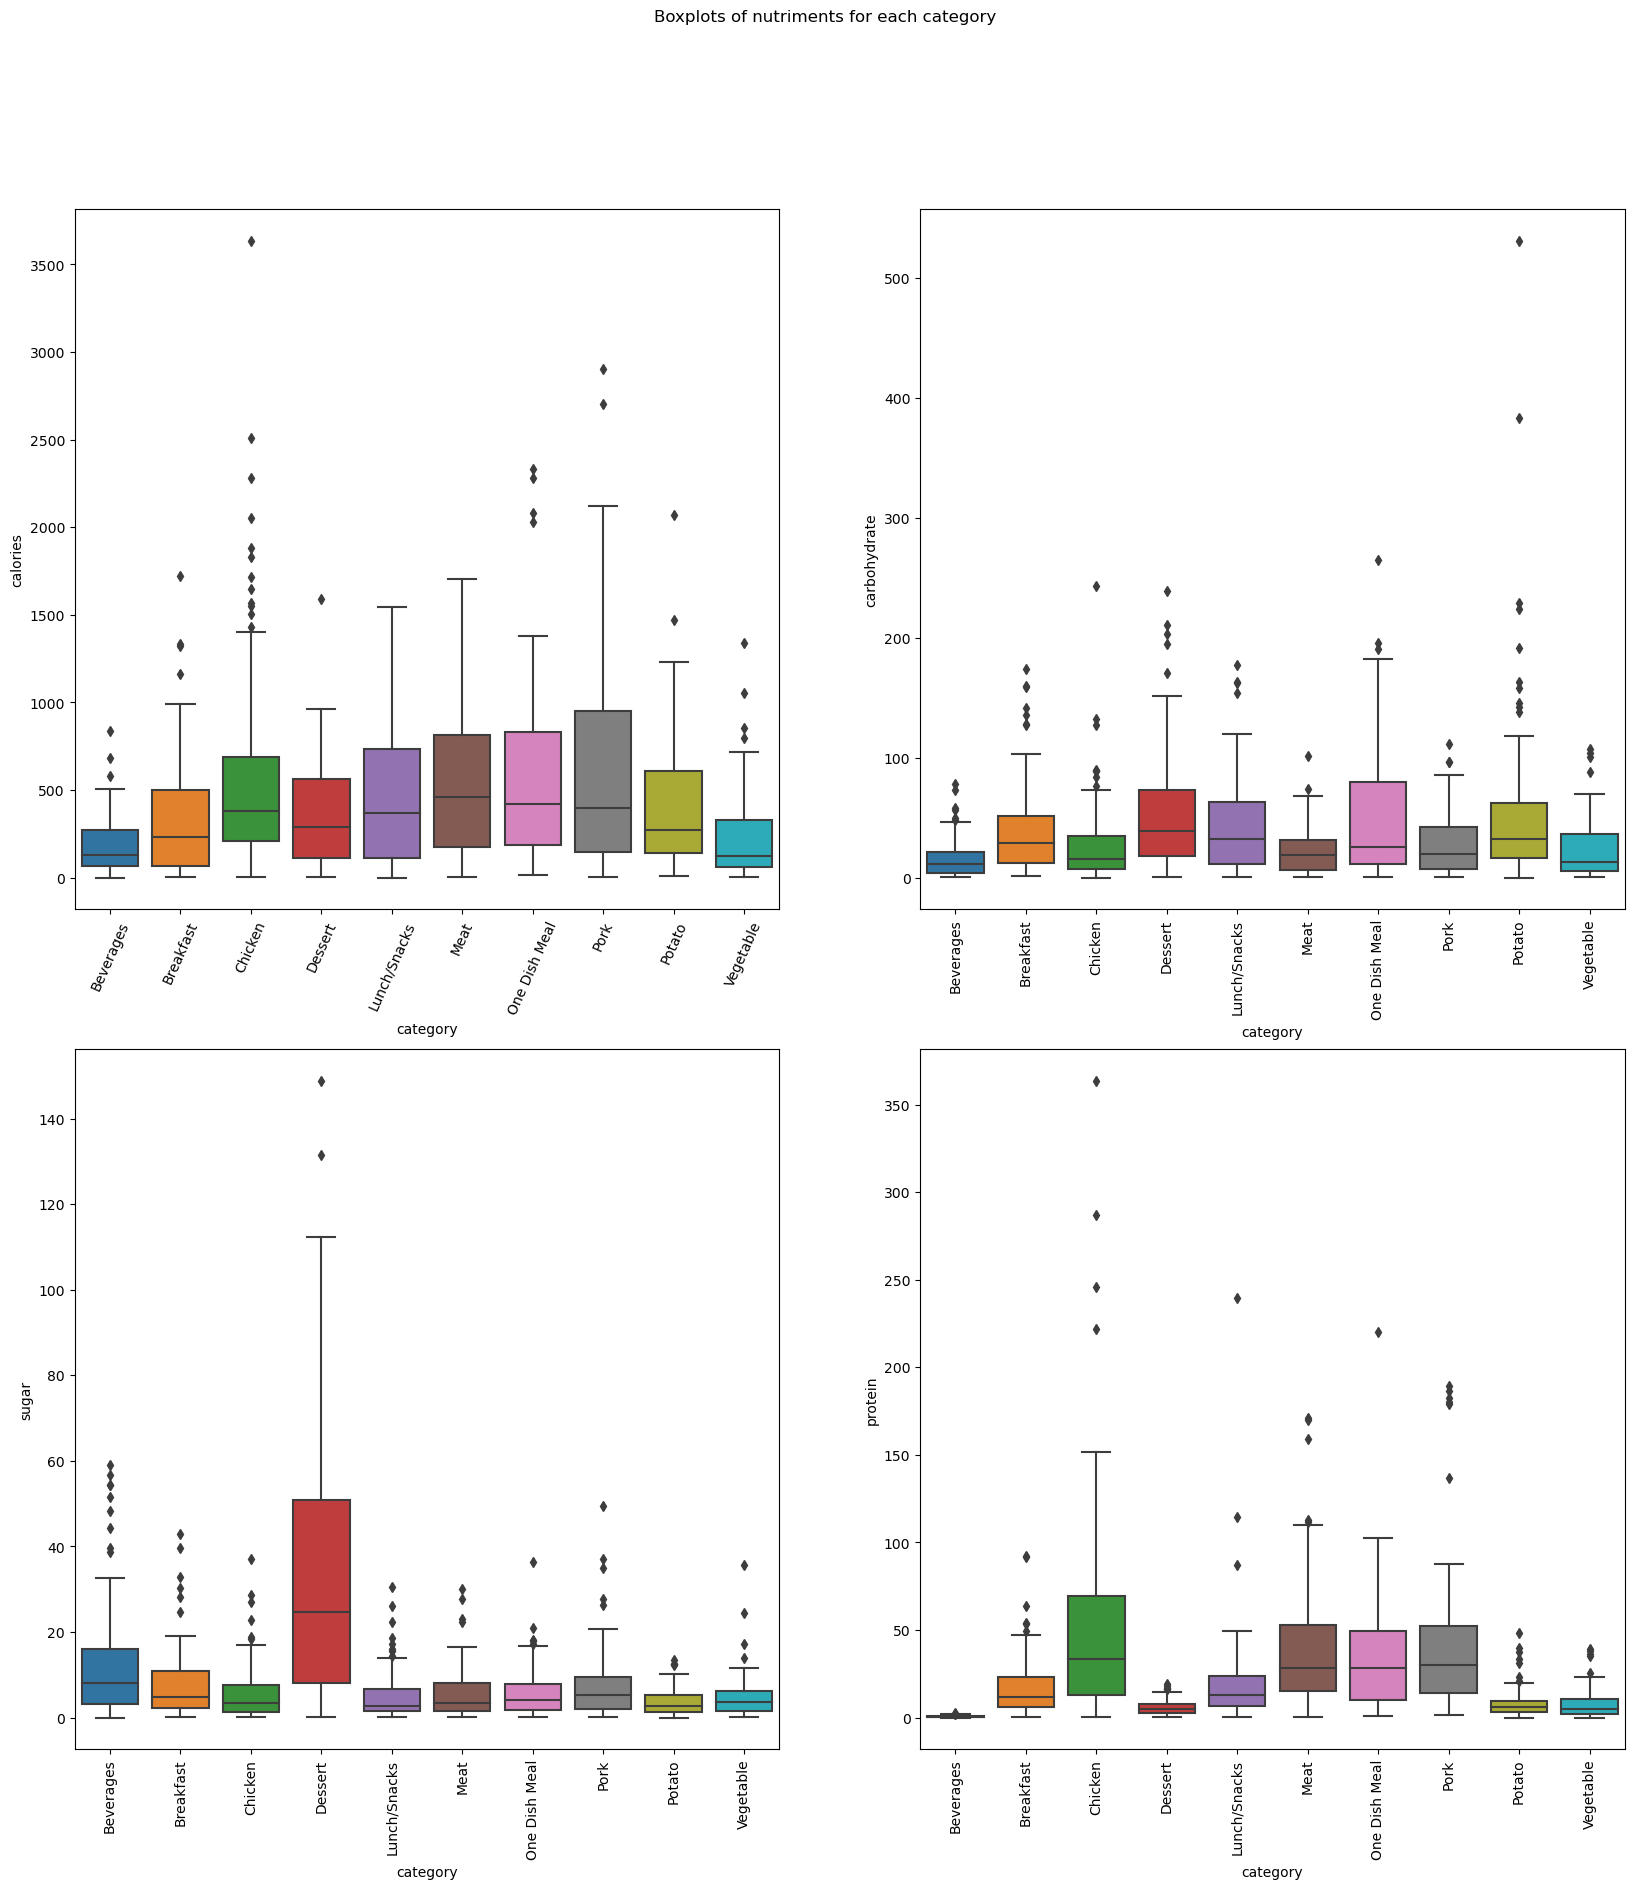

In [16]:
fig, axs = plt.subplots(2,2, figsize = [20,20])
fig.suptitle('Boxplots of nutriments for each category')
axs[0,0].tick_params(axis = 'x', rotation = 66)
axs[1,0].tick_params(axis = 'x', rotation = 90)
axs[0,1].tick_params(axis = 'x', rotation = 90)
axs[1,1].tick_params(axis = 'x', rotation = 90)

sns.boxplot(data = data_exp, x= 'category', y = 'calories',ax = axs[0,0])
sns.boxplot(data = data_exp, x= 'category', y = 'sugar',ax = axs[1,0])
sns.boxplot(data = data_exp, x= 'category', y = 'carbohydrate',ax = axs[0,1])
sns.boxplot(data = data_exp, x= 'category', y = 'protein',ax = axs[1,1])

Let us see if the amount of nutriments is related to popularity. It does not seem to be the case.

[Text(0, 0, 'Low'), Text(1, 0, 'High')]

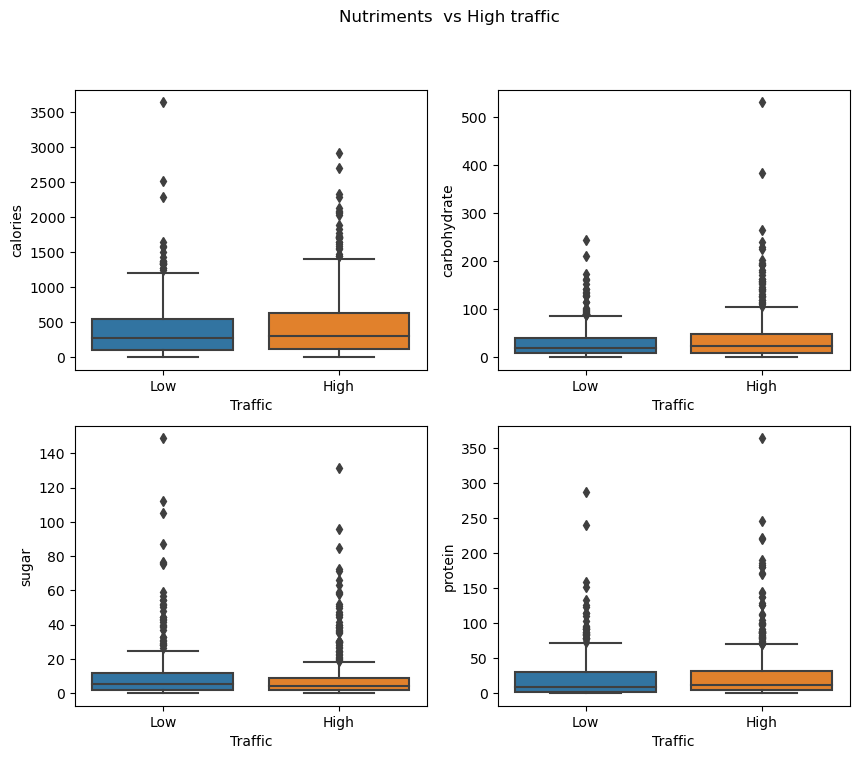

In [17]:
fig, axs = plt.subplots(2,2, figsize = [10,8])
fig.suptitle('Nutriments  vs High traffic')

sns.boxplot(data = data_exp, x= 'high_traffic', y = 'calories',ax = axs[0,0])
axs[0,0].set_xlabel('Traffic')
axs[0,0].set_xticklabels(['Low', 'High'])

sns.boxplot(data = data_exp, x= 'high_traffic', y = 'sugar',ax = axs[1,0])
axs[1,0].set_xlabel('Traffic')
axs[1,0].set_xticklabels(['Low', 'High'])

sns.boxplot(data = data_exp, x= 'high_traffic', y = 'carbohydrate',ax = axs[0,1])
axs[0,1].set_xlabel('Traffic')
axs[0,1].set_xticklabels(['Low', 'High'])

sns.boxplot(data = data_exp, x= 'high_traffic', y = 'protein',ax = axs[1,1])
axs[1,1].set_xlabel('Traffic')
axs[1,1].set_xticklabels(['Low', 'High'])


We plot the following kde plot of each nutriment against any other, separating high traffic and low traffic recipes in order to see more precisely if some nutriments have a particular importance regarding the popularity.

The 2 kind of popularity for recipes seem to have the same behaviour. These features will probably not be of the greatest importance.

The plots on the diagonal show that the nutriments distributions are skewed. We will consequently impute the missing values with the median.

Text(0.5, 1.05, 'Pairwise comparaison of nutriments distribution: high traffic vs low traffic')

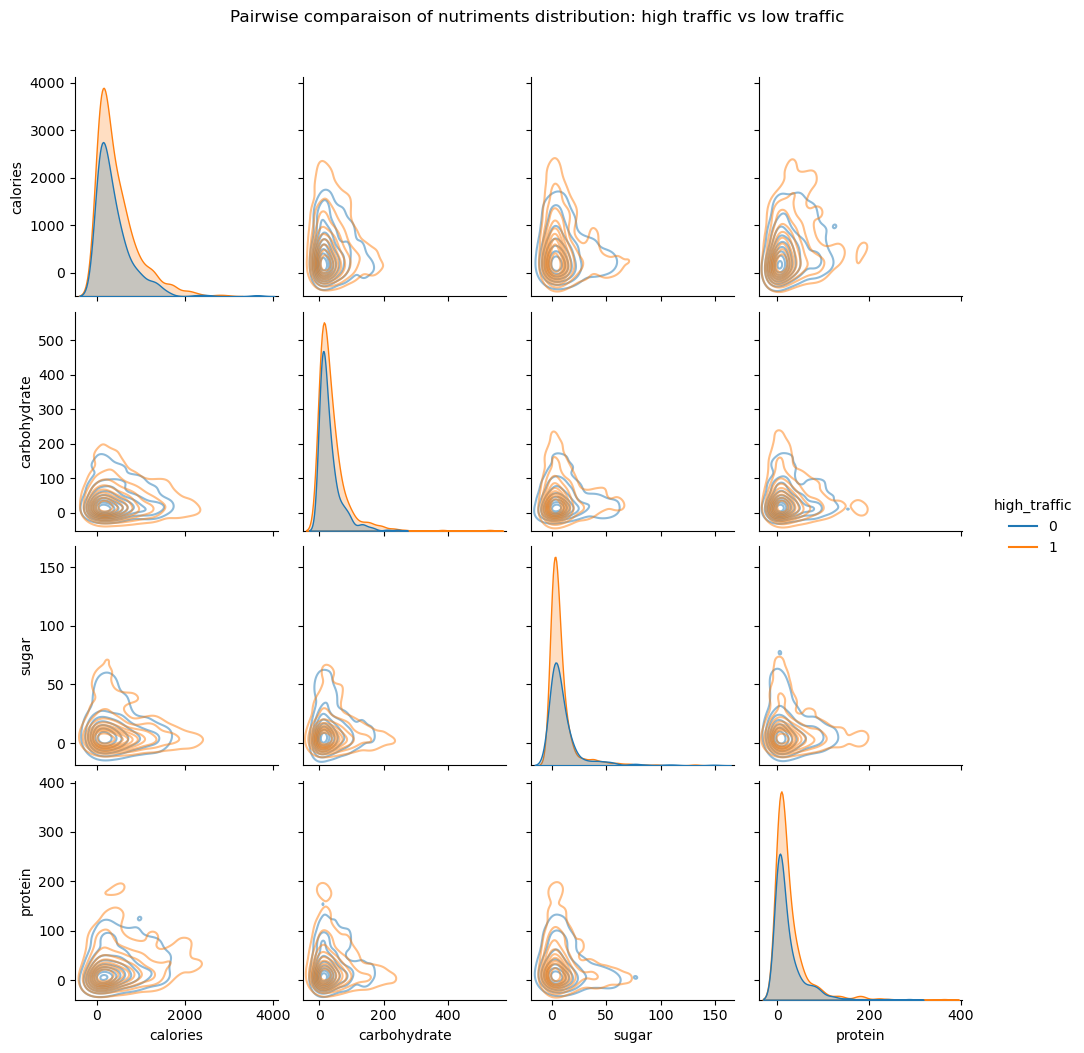

In [18]:
sns.pairplot(data = data_exp, hue = 'high_traffic', kind = 'kde',plot_kws={'alpha':0.5})
plt.suptitle('Pairwise comparaison of nutriments distribution: high traffic vs low traffic', y = 1.05)


**Model Development**

Split our data between training and testing parts. 80 % train, 20% test.

In [19]:
X = data.drop('high_traffic', axis = 1)
y = data['high_traffic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

Let us deal with outliers. As seen above, we only need to deal with few extreme high values. We are going to cut using the 97.5% quantile. This will make us drop at most 10% of our dataset (if there is no intersection between outliers from different columns). This amount of drop is reasonnable to train a model.

We first compute our threshold that we store in a series, we will cut our data after the imputation, to avoid suppressing the rows with NaN values.

In [20]:
outlier_threshold = X_train[['calories','carbohydrate','sugar','protein']].quantile(0.975)
outlier_threshold

calories        1695.012
carbohydrate     152.628
sugar             51.722
protein          126.974
Name: 0.975, dtype: float64

We now compute 'impute' which is a groupby DataFrame, grouped along 'category' and 'servings' and with which we compute the median to impute as precisely as possible the missing values.

To avoid data leakage, 'impute' is only computed on X_train.

We choose to take the median because as we saw in the plots in the previous section, our values are skewed.

The 'imputing' imputes a dataset with the corresponding values from 'impute'.

In [21]:
impute = X_train.groupby(['category','servings']).median()

def imputing(data):
    for col in ['calories','carbohydrate','sugar','protein']:
        for cat in data.category.unique():
                for nb in data.servings.unique():
                    data.loc[(data['servings']== nb) & (data['category']== cat) & (data[col].isna()),col]=impute.loc[(cat,nb),col]
    return data

We nom impute our missing values on X_train and X_test. We also do a one-hot encoding on the categorical features "servings" and "category".

In [22]:
X_train_final = pd.get_dummies(imputing(X_train))
X_test_final = pd.get_dummies(imputing(X_test))

Now, drop the outlier rows.

In [23]:
outlier_threshold = X_train[['calories','carbohydrate','sugar','protein']].quantile(0.975)
for i, col in enumerate(['calories','carbohydrate','sugar','protein']):
    y_train = y_train[X_train_final[col]<= outlier_threshold[col]]
    X_train_final = X_train_final[X_train_final[col]<= outlier_threshold[col]]

In [24]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 341 to 404
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calories                683 non-null    float64
 1   carbohydrate            683 non-null    float64
 2   sugar                   683 non-null    float64
 3   protein                 683 non-null    float64
 4   category_Beverages      683 non-null    bool   
 5   category_Breakfast      683 non-null    bool   
 6   category_Chicken        683 non-null    bool   
 7   category_Dessert        683 non-null    bool   
 8   category_Lunch/Snacks   683 non-null    bool   
 9   category_Meat           683 non-null    bool   
 10  category_One Dish Meal  683 non-null    bool   
 11  category_Pork           683 non-null    bool   
 12  category_Potato         683 non-null    bool   
 13  category_Vegetable      683 non-null    bool   
 14  servings_1              683 non-null    bool 

Let us check there is no strong correlation between our features.

<Figure size 1500x1500 with 0 Axes>

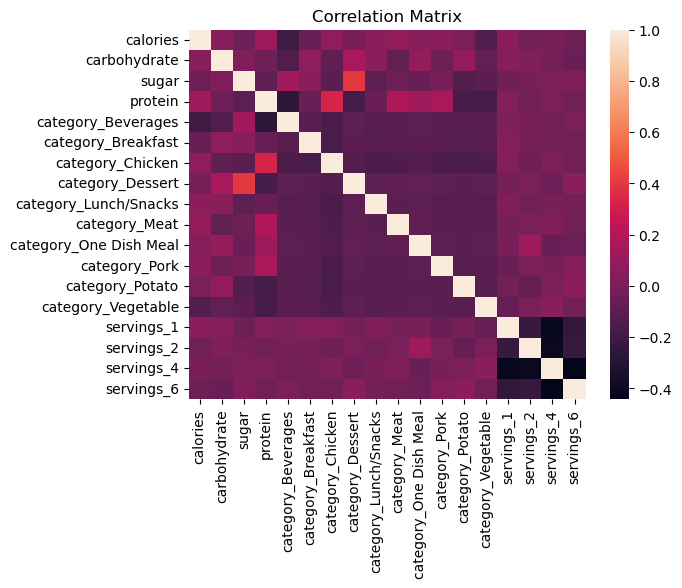

<Figure size 1500x1500 with 0 Axes>

In [25]:
correlation = X_train_final.corr()
plt.title('Correlation Matrix')
sns.heatmap(correlation, annot = False)
plt.figure(figsize=(15, 15))

The type of machine learning problem we are concerned here is a supervised learning classification problem on which we want to maximise precision.

Let us use DummyClassifier as a baseline model. We choose this one as it is the simplest classification model. As 'True' is the most frequent class label in the column 'high_traffic, the default 'prior' strategy of DummyClassifier is a perfect modelization of the current decision process, as described in the email.

We get a precision of 0.6, not reaching the threshold of 0.8 required by the product team, but corresponding to their current precision.

In [26]:
dummy =  DummyClassifier(random_state = 42)
dummy.fit(X_train_final,y_train)
y_pred_dummy = dummy.predict(X_test_final)
precision_dummy = precision_score(y_test,y_pred_dummy).round(2)
print(f'DummyClassifier precision = {precision_dummy}')

DummyClassifier precision = 0.61


Let us now try different models: RandomForestClassifier, SVC and LogisticRegression. We will choose the best one.

These three models are classification models, which is the type of model we are looking for here. We will do some hyperparameter tuning using GridSearchCV. This will also help choose which scaler (MinMaxScaler or StandardScaler) to apply to the numerical columns.

Since we are trying to predict if a recipe will bring high traffic, the scoring method used for GridSearchCV is 'precision'. We print the score for each model, along with the best parameters.

*RandomForestClassifier*

In [27]:
pipeRFC = Pipeline([
('preprocesser', ColumnTransformer([('scaler',StandardScaler(),['calories', 'carbohydrate', 'sugar', 'protein'])], remainder = 'passthrough')),
('classifier', RandomForestClassifier(random_state = 42))
])

parameters = {'preprocesser__scaler': [StandardScaler(), MinMaxScaler()],
 'classifier__criterion': ['gini', 'entropy', 'log_loss'],
 'classifier__n_estimators': [10,20,50,100,200],
 'classifier__max_depth': [2,5,10,15],
 'classifier__bootstrap': [True,False],
 'classifier__n_jobs': [-1]
}
 
gridRFC = GridSearchCV(pipeRFC, parameters, cv=5, scoring = 'precision').fit(X_train_final, y_train)

print('Test set score for Random Forest Classifier : ' + str(gridRFC.score(X_test_final, y_test)))

Test set score for Random Forest Classifier : 0.8155339805825242


In [28]:
best_params = gridRFC.best_params_
print(best_params)

{'classifier__bootstrap': True, 'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__n_estimators': 200, 'classifier__n_jobs': -1, 'preprocesser__scaler': StandardScaler()}


*SVC*

In [29]:
pipeSVC = Pipeline([
('preprocesser', ColumnTransformer([('scaler',StandardScaler(),['calories', 'carbohydrate', 'sugar', 'protein'])],remainder = 'passthrough')),
('classifier', SVC(random_state = 420, probability = True))
])

parameters = {'preprocesser__scaler': [StandardScaler(), MinMaxScaler()],
 'classifier__C': [0.01,0.1,1,2,10],
 'classifier__gamma': [1,0.1,0.01,0.001],
 'classifier__kernel': [ 'rbf', 'poly', 'sigmoid','linear']
}
 
gridSVC = GridSearchCV(pipeSVC, parameters, cv=5, scoring = 'precision').fit(X_train_final, y_train)

print('Test set score for SVC: ' + str(gridSVC.score(X_test_final, y_test)))

Test set score for SVC: 0.8514851485148515


In [30]:
best_params = gridSVC.best_params_
print(best_params)

{'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf', 'preprocesser__scaler': MinMaxScaler()}


*LogisticRegression*

In [31]:
pipeLR = Pipeline([
('preprocesser', ColumnTransformer([('scaler',StandardScaler(),['calories', 'carbohydrate', 'sugar', 'protein'])],remainder = 'passthrough')),
('classifier', LogisticRegression(random_state = 42))
])

parameters = {'preprocesser__scaler': [StandardScaler(), MinMaxScaler()],
 'classifier__penalty': ['l1','l2','elasticnet'],
 'classifier__C': [0,0.1, 1,2,10],
 'classifier__solver': ['liblinear','newton_cholesky'],
              'classifier__max_iter':[5,10, 15,25, 50]
}
 
gridLR = GridSearchCV(pipeLR, parameters, cv=5, scoring = 'precision').fit(X_train_final, y_train)

print('Test set score: ' + str(gridLR.score(X_test_final, y_test)))

/home/alex/anaconda3/envs/gudhi/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/anaconda3/envs/gudhi/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/anaconda3/envs/gudhi/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/anaconda3/envs/gudhi/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/anaconda3/envs/gudhi/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/alex/anaconda3/envs/gudhi/lib/python3.10/sit

Test set score: 0.8543689320388349


/home/alex/anaconda3/envs/gudhi/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1100 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/gudhi/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alex/anaconda3/envs/gudhi/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/alex/anaconda3/envs/gudhi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.

In [32]:
best_params = gridLR.best_params_
print(best_params)

{'classifier__C': 1, 'classifier__max_iter': 5, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'preprocesser__scaler': MinMaxScaler()}


**Model Evaluation**

RandomForestClassifier, SVC and LogisticRegression got a precision score above 80% as requested:
- RandomForest precision: 0.82
- SVC precision: 0.85
- LogReg precision: 0.85

They all performed better than the baseline model, DummyClassifier, and so they each one of them would represent an improvement in the decision process.

Let us print a bit more details on the evaluations for these models.

In [33]:
y_pred_LR = gridLR.predict(X_test_final)
y_pred_SVC = gridSVC.predict(X_test_final)
y_pred_RFC = gridRFC.predict(X_test_final)

dict_score = {'precision': [precision_score(y_test, y_pred_RFC), precision_score(y_test, y_pred_SVC), precision_score(y_test, y_pred_LR)],
                'accuracy': [accuracy_score(y_test, y_pred_RFC), accuracy_score(y_test, y_pred_SVC), accuracy_score(y_test, y_pred_LR)],
                 'recall': [recall_score(y_test, y_pred_RFC), recall_score(y_test, y_pred_SVC), recall_score(y_test, y_pred_LR)],
                   'F1 Score': [f1_score(y_test, y_pred_RFC), f1_score(y_test, y_pred_SVC), f1_score(y_test, y_pred_LR)]  }

pd.DataFrame(dict_score, index = ['RFC', 'SVC', 'LogReg'])

,precision,accuracy,recall,F1 Score
RFC,0.815534,0.736842,0.730435,0.770642
SVC,0.851485,0.768421,0.747826,0.796296
LogReg,0.854369,0.778947,0.765217,0.807339


In [34]:
pd.DataFrame(dict_score, index = ['RFC', 'SVC', 'LogReg'])['precision'].round(3)

RFC       0.816
SVC       0.851
LogReg    0.854
Name: precision, dtype: float64

The precision of SVC and Logistic Regression are extremely close (~0.3%). Logisitc Regression scores slightly better. Logistic Regression outperforms SVC for accuracy, recall and f1 scores.

To confirm the choice of the Logistic Regression model, we plot the following ROC curves.

As the AUC of LogisticRegression is closer to 1 than the AUC of SVC, we conclude that LogisticRegression is more robust. 

Logistic Regression is also known for its interpretability: we can easily access the coefficients at stake in the fitted model and thus get the features' importance.

Thus we will select the LogReg model.

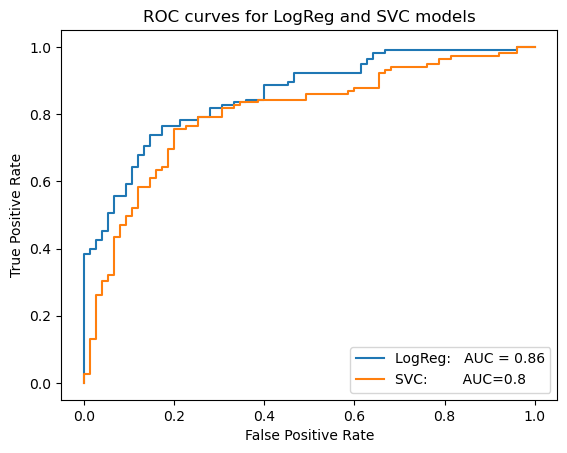

In [35]:
y_pred_probaLR = gridLR.best_estimator_.predict_proba(X_test_final)[:,1]
fprLR, tprLR, _ = roc_curve(y_test,  y_pred_probaLR)

y_pred_probaSVC = gridSVC.best_estimator_.predict_proba(X_test_final)[:,1]
fprSVC, tprSVC, _ = roc_curve(y_test,  y_pred_probaSVC)

aucLR = roc_auc_score(y_test, y_pred_probaLR).round(2)
aucSVC = roc_auc_score(y_test, y_pred_probaSVC).round(2)

plt.plot(fprLR, tprLR, label = f'LogReg:   AUC = {aucLR}')
plt.plot(fprSVC, tprSVC, label = f'SVC:        AUC={aucSVC}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for LogReg and SVC models')
plt.legend(loc = 4)


We save the Logistic Regression model.

In [36]:
joblib.dump(gridLR.best_estimator_, 'recipe_traffic_model.pkl')

['recipe_traffic_model.pkl']

The predictions of the Logistic Regression model are the following:

Text(0.5, 1.0, 'Confusion Matrix of tuned Logistic Regression Model')

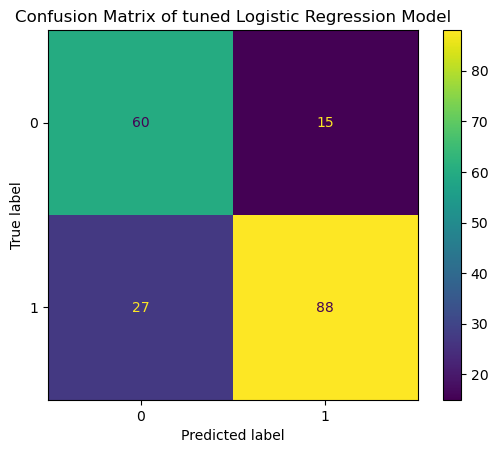

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_LR)
plt.title('Confusion Matrix of tuned Logistic Regression Model')

To help us make recommendation for the business, let us look at feature importance.

We plot the coefficients at stakes in the fitted Logistic Regression model.

The category of meal is important: Vegetable, Potato and Pork seem to be popular, wheras Beverages, Breakfast and Chicken not.
High calories are not good for high traffic.

In [38]:
coeff = pd.DataFrame([X_train_final.columns, gridLR.best_estimator_['classifier'].coef_[0]]).transpose()
coeff.columns = ['feature', 'coeff']
coeff.sort_values('coeff', inplace = True)

Text(0.5, 1.0, 'Coefficients of features in the tuned LogReg model')

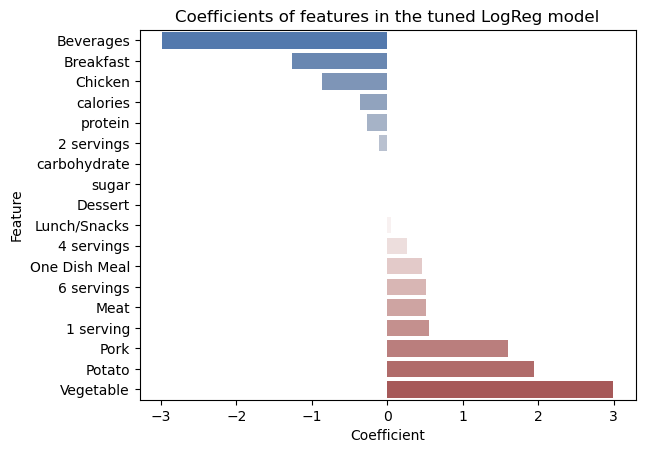

In [39]:
fig, ax = plt.subplots()
#plt.xticks(rotation = 90)
sns.barplot(data = coeff, y = 'feature', x = 'coeff', palette = "vlag", ax = ax)
ax.set_yticklabels(['Beverages','Breakfast','Chicken','calories','protein', '2 servings', 'carbohydrate','sugar','Dessert','Lunch/Snacks','4 servings', 'One Dish Meal', '6 servings', 'Meat', '1 serving', 'Pork', 'Potato', 'Vegetable'])
ax.set_ylabel('Feature')
ax.set_xlabel('Coefficient')

plt.title('Coefficients of features in the tuned LogReg model')

**Buisness Metric**

We propose the proportion on the website of recipe generating high traffic as a business metric. Indeed, this is a good indicator of whether the chosen recipe was popular or not on average. Moreover, this is precisely the precision of the predictive model implemented for improving the decision process on which recipe to select.


The goal of this project was to be able to predict which recipes will be popular 80% of the time. Consequently, the KPI we are interested in is the precision, with a threshold at 0.8.

Consequently, we will compare the precisions of our models to each other and to the 0.8 threshold to choose the best one for this situation.

As computed in the Exploratory Analysis section, there are 60% of high traffic recipes on the website, meaning that the decision process currently at use has a precision of 0.6. After reading the current decision process, we fitted a DummyClassifier to mimic this decision process. Its precision score is ~60%.

To predict if a recipe will bring high traffic, we tried three different models:
- Random Forest Classifier, precision: 0.82
- Logistic Regression, precision: 0.85
- SVC, precision: 0.85

The three models outperform the DummyClassifier and the current decision process: they all scored above 0.6. The models are validated by the buisness criteria of precision: they all scored above 0.8.

Since Random Forest Classifier has less precision, we will not choose this one. Since the two other models, SVC and LogReg, almost have the same precision, we have to choose which model to select using aditionnal indicators.

We will keep the Logistic Regression model instead of SVC for three
reasons:
- Logistic Regression is easier to interpret: from the coefficients, we can deduce the features' importance,
- with similar precision, LogisticRegression outperforms SVC in accuracy, recall and f1 scores,
- the auc of LogReg is higher than the auc of SVC, meaning it has a better separability and is thus more robust.

**Final Summary**

We were tasked to predict which recipes will lead to high traffic. To do so, after data validation and exploration, we developed 3 models and chose the most performing one.

The current decision process to select recipes to put online has a precision of 0.6, while the proposed model, using Logistic Regression, leads to a precision of 0.85. Consequently, the product team should start using this LogReg model instead of their current one.

Thanks to the development of the new model, we were able to identify features leading to high traffic recipes:
- Vegetables
- Potato
- Pork

The product team could focus on these categories of meals.

We also identified features leading to low traffic recipes:
- Beverage
- Breakfast
- Chicken
- Calories

The product team should avoid these.